In [5]:
pip install gender_guesser

Defaulting to user installation because normal site-packages is not writeable
  Using cached gender_guesser-0.4.0-py2.py3-none-any.whl (379 kB)
Note: you may need to restart the kernel to use updated packages.


In [280]:
import dhlab as dh
import dhlab.api.dhlab_api as api
import pandas as pd
import gender_guesser.detector as gg
import os

from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import fcluster

from collections import Counter
dh.css()

In [10]:

#import numpy as np

# # suppose you have the following vectors:
# v1 = np.array([[0.5, 0.3, 0.2]])
# v2 = np.array([[1, 0, 0]])
# v3 = np.array([[0, 1, 0]])
# # print(v1)
# # stack vectors vertically to form a matrix
# V = np.vstack((v1, v2, v3))

# # compute cosine similarity
# cos_sim = cosine_similarity(V)

# print(cos_sim)


In [11]:
def check_heads(df, word = 'jeg', cols = ['head_lemma', 'head_head_lemma'], variants = True):
    """If variants then all printed versions capitalized and so on"""
    if variants:
        wordforms = [word, word.upper(), word.lower(), word.capitalize()]
        res = pd.DataFrame(pd.concat([df[df.token.isin(wordforms)].groupby(col).sum('frekv').sort_values(by='frekv', ascending=False) for col in cols], axis = 1).sum(axis = 1), columns = ['frekv'])
        #res.columns = ['frekv']

    else:
        res = df[df.token == word].groupby('head').sum().sort_values(by='frekv', ascending=False)
    return res



def describe_pos(df, features = ['PRON', 'PROPN']):
    sumpos = df.groupby('pos').sum()
    countpos = df.groupby('pos').count()[['token']]
    r = pd.concat([sumpos.loc[features], countpos.loc[features]], axis = 1)
    r.columns = ['sum', 'count']
    return r
    
def describe_ner(df, features = ['PER']):
    nersum = df.groupby('ner').sum()
    nercount = df.groupby('ner').count()['frekv']
    r = pd.concat([nersum.loc[features], nercount.loc[features]], axis = 1)
    r.columns = ['sum', 'count']
    return r

def pronouns(df):
    return df[df.pos == 'PRON'].groupby("lemma").sum('frekv').sort_values(by='frekv', ascending = False)

def propriums(df):
    props =  df[df.pos == 'PROPN'].groupby("token").sum('frekv').sort_values(by='frekv', ascending = False)
    #props['gender'] = [get_gender(x) for x in props.index]
    return props
    
def get_gender(name):
    return gg.Detector().get_gender(name)

# Hent filene

In [177]:
mappe = "parsed_files"
mfiles = !ls parsed_files
files = [os.path.join(mappe, fn) for fn in mfiles]

## Rekonstruer urnene

In [178]:
urns = [f"URN:NBN:no-nb_digibok_{f.split('_')[-1].split('.pqt')[0]}" for f in files]

In [179]:
corpus = api.get_metadata(urns)

In [180]:
corpus = corpus[['dhlabid', 'urn','authors', 'title', 'year', 'langs', 'publisher','subjects','ddc','genres']]

In [379]:
corpus[['urn','authors', 'title', 'year', 'publisher','subjects','ddc','genres']].sample(10).style.hide()

urn,authors,title,year,publisher,subjects,ddc,genres
URN:NBN:no-nb_digibok_2014013105041,"Knausgård , Karl Ove",Min kamp : roman : Tredje bok,2009,Oktober,Fictional Works / norske / romaner / 1970-tallet / selvbiografier / 1980-tallet / oppvekstroman / sørlandet,839.823 / 839.82,biography / novel
URN:NBN:no-nb_digibok_2013120608099,"Gulliksen , Geir",Våkner om natten og vil noe annet : roman,2007,Oktober,norske / romaner / 2000-tallet,839.823,novel
URN:NBN:no-nb_digibok_2007082404017,"Ambjørnsen , Ingvar",San Sebastian blues,1990,Cappelen,norske / romaner / 1980-tallet,839.823 / 839.82,fiction
URN:NBN:no-nb_digibok_2018031248041,"Hamsun , Knut",August : roman. 2,1930,Gyldendal,,839.82,
URN:NBN:no-nb_digibok_2008092604049,"Nesbø , Jo",Flaggermusmannen : roman,1999,Aschehoug,kriminalromaner / skjønnlitteratur,839.823,fiction
URN:NBN:no-nb_digibok_2008081904025,"Hjorth , Vigdis","Takk, ganske bra : en norsk roman i tre deler",1998,Cappelen,norske / romaner / 1990-tallet,839.823,fiction
URN:NBN:no-nb_digibok_2007070400018,"Hoel , Sigurd",Ettertanker,1980,Gyldendal,norske / essays,839.82 / 839.94,fiction
URN:NBN:no-nb_digibok_2009031004008,"Holt , Anne",Det som er mitt,2002,Cappelen,kriminalromaner / skjønnlitteratur / krim / spenning,839.823,fiction
URN:NBN:no-nb_digibok_2008090800100,"Holt , Anne",Blind gudinne,1999,Cappelen,skjønnlitteratur/voksen,839.823,fiction
URN:NBN:no-nb_digibok_2014110508077,"Christensen , Lars Saabye",Mitt danske album,2011,Cappelen Damm,norsk / litteratur / lyrikk / danmark,839.82 / 839.821,poetry


In [181]:
corpus[corpus.authors.str.contains('Solstad')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
24,100012888,URN:NBN:no-nb_digibok_2010082403062,"Solstad , Dag","Arild Asnes, 1970 : roman",1996,nob,Bokklubben nye bøker,,839.823,novel
26,100042200,URN:NBN:no-nb_digibok_2011030820008,"Solstad , Dag",Gymnaslærer Pedersens beretning om den store p...,1992,nob,Oktober,,839.823,novel
27,100499333,URN:NBN:no-nb_digibok_2011050920007,"Solstad , Dag",Spiraler : noveller,2001,nob,Oktober,,839.823,short story
28,100499351,URN:NBN:no-nb_digibok_2011051020013,"Solstad , Dag",Svingstol : en samling prosatekster,1967,nob,Aschehoug,skjønnlitteratur/voksen / norsk / prosa / 1960...,839.93,short story
51,100217326,URN:NBN:no-nb_digibok_2014072908100,"Solstad , Dag",Krig 1940 : roman,2001,nob,Oktober,,839.823,novel


In [182]:
corpus[corpus.authors.str.contains('Hamsun')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
16,100031870,URN:NBN:no-nb_digibok_2009031004082,"Hamsun , Knut",Markens grøde,1999,nob,Gyldendal,,839.823,fiction
25,100040955,URN:NBN:no-nb_digibok_2011022205198,"Hamsun , Knut",Det vilde kor : digte,1968,nob,Bokklubben,Dikt / Litteratur / Norsk litteratur / skjønnl...,839.82 / S 839.91,
40,100130846,URN:NBN:no-nb_digibok_2013012306172,"Hamsun , Knut",Victoria,2009,nob,Gyldendal,,839.823 / 839.82,novel
58,100345759,URN:NBN:no-nb_digibok_2017072407123,"Hamsun , Knut",Pan,1967,nob,Gyldendal,skjønnlitteratur/voksen,839.82,
60,100366912,URN:NBN:no-nb_digibok_2018031248041,"Hamsun , Knut",August : roman. 2,1930,nob,Gyldendal,,839.82,


In [183]:
corpus[corpus.authors.str.contains('Hoel')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
0,100568644,URN:NBN:no-nb_digibok_2007013001006,"Hoel , Sigurd",En dag i oktober : roman,1954,nob,Gyldendal,roman,839.93,fiction
1,100023856,URN:NBN:no-nb_digibok_2007070400018,"Hoel , Sigurd",Ettertanker,1980,nob,Gyldendal,norske / essays,839.82 / 839.94,fiction
22,100577416,URN:NBN:no-nb_digibok_2010061223001,"Hoel , Sigurd",Trollringen,1998,nob,Gyldendal,,839.82 / 839.823,fiction
52,100225833,URN:NBN:no-nb_digibok_2014091608101,"Hoel , Sigurd",Fjorten dager før frostnettene : roman,1975,nob,Gyldendal,,839.93,fiction
56,100249391,URN:NBN:no-nb_digibok_2015050748054,"Hoel , Sigurd",Veien vi gaar : noveller,1922,nob,Gyldendal,,839.82,


In [184]:
corpus[corpus.authors.str.contains('Uri')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
17,100151554,URN:NBN:no-nb_digibok_2009042004109,"Uri , Helene",Dyp rød 315 : roman,2002,nob,Gyldendal,norske / romaner / 2000-tallet,839.823,fiction
32,100060316,URN:NBN:no-nb_digibok_2011101408121,"Uri , Helene",De beste blant oss : roman,2006,nob,Gyldendal,Linguistics / Faculty / Universities / Literat...,839.823,novel
49,100211089,URN:NBN:no-nb_digibok_2014061706080,"Uri , Helene",Kjerringer : roman,2011,nob,Gyldendal,norsk / litteratur / norske / romaner / 2010-t...,839.823,novel
62,100376882,URN:NBN:no-nb_digibok_2018072748088,"Uri , Helene",Rydde ut : roman,2014,nob,Gyldendal,,839.823,novel
73,100581430,URN:NBN:no-nb_digibok_2021092148045,"Uri , Helene",Hålke : roman,2017,nob,Gyldendal,Ekteskap og parforhold / Ekteskap og parforhol...,839.823,novel / text


In [17]:
corpus[corpus.urn.str.contains('2015050648108')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres


In [186]:
parses = {f:pd.read_parquet(f) for f in files}

In [ ]:
pd.Series(parses.keys()).sample(1).values(0)

In [382]:
def sample_text():
    return parses[pd.Series(parses.keys()).sample(1).values[0]]

In [389]:
check_heads(sample_text(), "oss", ['dep','head']).sort_values(by='frekv', ascending=False).head(10)

,frekv
obj,30.0
obl,21.0
nmod,10.0
iobj,7.0
gifte,4.0
venter,2.0
gjøre,2.0
imellem,2.0
giftet,2.0
La,2.0


In [402]:
sample_text().sample(5)

,token,lemma,pos,dep,head,head_lemma,head_pos,head_head,head_head_lemma,head_head_pos,frekv
80574,grunn,grunn,NOUN,obj,hadde,ha,VERB,hadde,ha,VERB,1
101929,jeg,jeg,PRON,nsubj,sa,si,VERB,sa,si,VERB,1
97141,ikke,ikke,PART,advmod,dyttet,dytte,VERB,dyttet,dytte,VERB,1
100055,jeg,jeg,PRON,nsubj,gjort,gjøre,VERB,kommer,komme,VERB,1
139223,ringte,ringe,VERB,conj,gikk,gå,VERB,vet,vite,VERB,1


In [187]:
def dtm(word):
    alldata = []
    for p in parses:
        han = check_heads(parses[p], word).head(20)
        auth = f"{p.split('/')[-1].split('_')[0]}"
        urnseries = f"{p.split('.pqt')[0].split('_')[-1]}"
        
        han.columns = [f"{auth}-{word}-{urnseries}"]
        alldata.append(han)
    dtm = pd.concat(alldata,axis = 1).fillna(0)
    return dtm

In [404]:
check_heads(sample_text(), 'han').head(10)

,frekv
tenke,118.0
vite,136.0
se,98.0
gå,95.0
ha,83.0
ta,77.0
si,66.0
bli,59.0
kjenne,61.0
huske,52.0


In [188]:
df = parses[files[10]]
df = df[df.pos == 'PROPN']
print(df["token dep head head_pos".split()].sample(10).style.hide().to_latex().replace('_','\_'))

\begin{tabular}{llll}
token & dep & head & head\_pos \\
Lin & flat:name & Oswald & PROPN \\
Lincoln & flat:name & Abraham & PROPN \\
lyon & obj & husker & VERB \\
Ilmari & obj & jamret & VERB \\
gulliksen & flat:name & geir & PROPN \\
War & flat:name & The & PROPN \\
Allehanda & flat:name & Enkopings & PROPN \\
Mai & obl & eldre & ADJ \\
Strasse & flat:name & Ulzener & PROPN \\
isbn & flat:name & larvik & PROPN \\
\end{tabular}



In [419]:
d = dtm('han').columns
res = list(set([random.choice(d) for a in range(8)]))

In [420]:
res

['Hoel-han-2007070400018',
 'Hjorth-han-2008081904025',
 'Christensen-han-2021102048032',
 'Hjorth-han-2008111904076',
 'Ambjørnsen-han-2008092604072',
 'Hamsun-han-2013012306172',
 'Solstad-han-2014072908100',
 'Lindell-han-2021021107543']

In [422]:
dtm('han')[res].head(10).style.format(precision=0).background_gradient(axis = 0)

,Hoel-han-2007070400018,Hjorth-han-2008081904025,Christensen-han-2021102048032,Hjorth-han-2008111904076,Ambjørnsen-han-2008092604072,Hamsun-han-2013012306172,Solstad-han-2014072908100,Lindell-han-2021021107543
ha,69,137,282,12,44,59,135,147
si,40,161,268,23,66,86,206,136
se,24,77,192,7,37,78,183,125
dra,0,0,0,4,0,0,0,27
ta,14,50,149,6,14,26,57,58
gå,14,87,182,7,33,86,90,65
gjøre,11,57,117,6,21,0,40,41
han,12,0,0,0,27,0,0,0
få,17,54,114,0,12,20,38,52
gi,0,0,0,0,0,0,0,0


In [190]:
#cosine_similarity(dtm('han')[0:2])

In [423]:
han_dtm =dtm('vi')/dtm('vi').sum()

In [192]:
hun_dtm = dtm('hun')/dtm('hun').sum()

In [193]:
han_dot = han_dtm.transpose().dot(han_dtm)

In [424]:
cos_df = cosine_similarity(dtm('vi').transpose())

In [425]:
han_cos = pd.DataFrame(cos_df,index = dtm('han').columns, columns=dtm('han').columns)

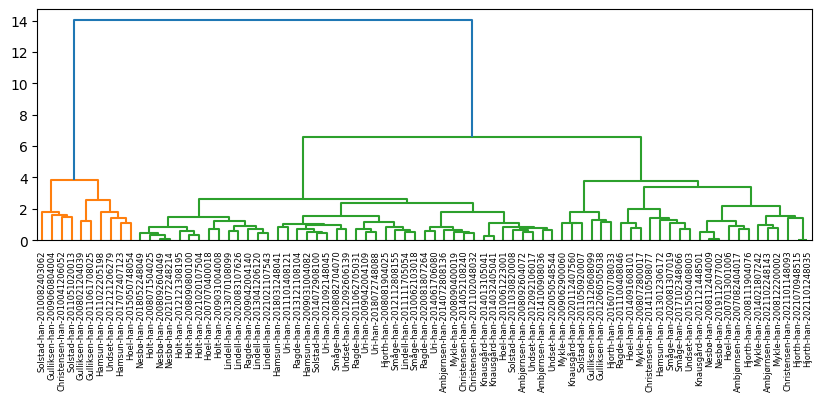

In [426]:


# assuming cos_df is your cosine similarity DataFrame

# 1 - cos_df is used to convert cosine similarity to dissimilarity (distance)
# 'ward' is one method you can use, others include 'single', 'complete', 'average'
linkage_matrix_han = linkage(1 - han_cos, method='ward')

# plot the dendrogram
# plt.figure(figsize=(10, 7))  
# dendrogram(linkage_matrix, labels=han_cos.columns.tolist())
# plt.show()
fig, ax = plt.subplots(figsize=(10, 3))
dendrogram(linkage_matrix_han, orientation='top', labels=han_cos.columns.tolist())
plt.savefig('han-dendro.png', bbox_inches='tight', dpi=300)
plt.show()


In [197]:
hun_cos = pd.DataFrame(cosine_similarity(dtm('hun').transpose()),index = dtm('hun').columns, columns=dtm('hun').columns)

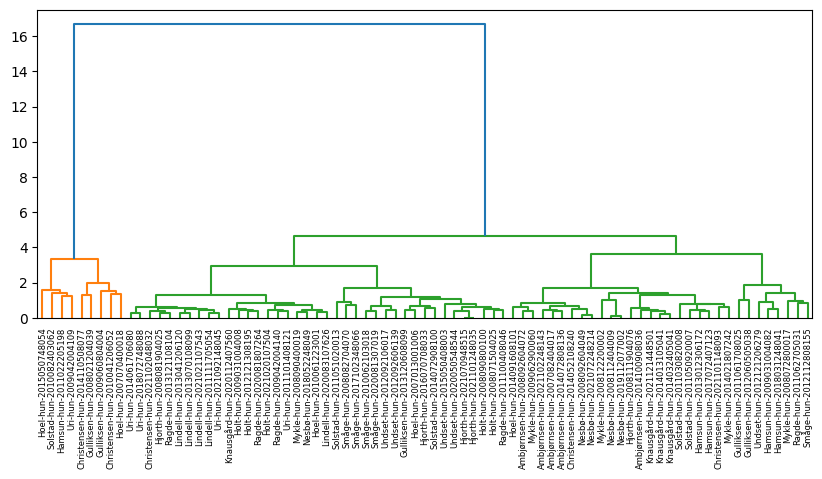

In [198]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# assuming cos_df is your cosine similarity DataFrame

# 1 - cos_df is used to convert cosine similarity to dissimilarity (distance)
# 'ward' is one method you can use, others include 'single', 'complete', 'average'
linkage_matrix = linkage(1 - hun_cos, method='ward')

# plot the dendrogram
plt.figure(figsize=(10, 7))  
dendrogram(linkage_matrix, labels=hun_cos.columns.tolist())
plt.savefig('hun-dendro.png', bbox_inches='tight', dpi=300)
plt.show()

In [365]:
import random

def cluster_display(cos_df, lm, max_d):
    cos_df['clusters'] = fcluster(lm, max_d, criterion='distance') 
    groups = cos_df.groupby('clusters').apply(lambda x: x.index.tolist())
    df = pd.DataFrame([Counter([x.split('-')[0] for x in g]) for g in groups])
    return df.fillna(0)

def cluster_random_display(cos_df, num_of_clusters=5):
    cos_df['clusters'] = [random.randint(0,num_of_clusters) for x in range(len(hun_cos))]
    groups = cos_df.groupby('clusters').apply(lambda x: x.index.tolist())
    df = pd.DataFrame([Counter([x.split('-')[0] for x in g]) for g in groups])
    return df.fillna(0)

In [427]:
cluster_display(han_cos.copy(), linkage_matrix_han, 2).style.format(precision=0).background_gradient(axis = 1)

,Christensen,Gulliksen,Solstad,Hamsun,Hoel,Undset,Holt,Lindell,Nesbø,Ragde,Hjorth,Småge,Uri,Ambjørnsen,Knausgård,Mykle
0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,5,4,3,1,0,0,0,0,0,0
4,0,0,1,2,0,1,0,1,0,2,1,3,4,0,0,0
5,2,0,1,0,1,2,0,0,0,1,0,0,1,3,2,1
6,0,2,1,0,0,0,0,0,0,0,1,0,0,0,1,1
7,1,0,0,1,1,1,0,0,0,1,0,2,0,0,0,1
8,0,0,0,0,1,0,0,0,2,0,1,0,0,1,1,0
9,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,2


In [369]:
cluster_random_display(hun_cos.copy(),5).style.format(precision=0).background_gradient(axis = 1)

,Hamsun,Hoel,Holt,Knausgård,Nesbø,Ragde,Solstad,Undset,Uri,Ambjørnsen,Christensen,Hjorth,Lindell,Småge,Gulliksen,Mykle
0,2,1,1,1,2,1,2,1,1,0,0,0,0,0,0,0
1,1,1,0,0,1,0,1,1,0,2,1,2,1,2,0,0
2,1,0,1,2,0,0,1,0,1,1,2,2,1,0,1,2
3,0,1,1,0,0,2,0,1,1,0,1,1,1,0,2,1
4,0,2,2,0,2,0,0,1,1,1,1,0,1,1,1,2
5,1,0,0,1,0,2,1,1,1,1,0,0,1,2,1,0


In [319]:
cluster_display(han_cos.copy(), linkage_matrix_han, 2).style.format(precision=0).background_gradient(axis = 1)

,Gulliksen,Hamsun,Undset,Christensen,Hjorth,Hoel,Mykle,Ragde,Solstad,Småge,Uri,Ambjørnsen,Holt,Knausgård,Lindell,Nesbø
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,2,1,2,0,0,0,0,0,0,0
5,0,2,0,0,0,0,0,0,0,1,2,0,0,0,0,0
6,0,0,2,0,0,1,1,0,2,0,1,2,1,0,0,0
7,0,0,2,3,1,1,2,2,1,1,2,1,4,1,5,5
8,1,2,0,0,3,0,0,2,0,3,0,2,0,3,0,0


In [374]:
cluster_random_display(han_cos.copy(), 8).style.format(precision=0).background_gradient(axis = 1)

,Ambjørnsen,Gulliksen,Holt,Knausgård,Nesbø,Småge,Undset,Christensen,Lindell,Mykle,Solstad,Hamsun,Hjorth,Hoel,Ragde,Uri
0,1,1,2,2,1,1,1,0,0,0,0,0,0,0,0,0
1,0,1,0,2,1,0,1,2,1,1,1,0,0,0,0,0
2,0,1,0,0,0,1,1,1,0,1,1,1,1,2,1,1
3,0,0,0,0,0,1,0,0,0,0,0,2,1,2,1,1
4,1,0,1,0,0,0,0,1,1,2,0,0,0,0,1,0
5,0,0,0,0,0,1,0,0,1,0,3,2,2,1,0,0
6,1,0,0,0,1,0,1,1,2,0,0,0,0,0,0,2
7,1,1,1,0,1,1,1,0,0,0,0,0,1,0,1,1
8,1,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0


In [37]:
dtm('han')

,Gulliksen-han-2008021204039,Gulliksen-han-2009060804004,Gulliksen-han-2011061708025,Gulliksen-han-2012060505038,Gulliksen-han-2013120608099,Hamsun-han-2009031004082,Hamsun-han-2011022205198,Hamsun-han-2013012306172,Hamsun-han-2017072407123,Hamsun-han-2018031248041,...,Undset-han-2012092106017,Undset-han-2012092606139,Undset-han-2012121206279,Undset-han-2015050408003,Undset-han-2020050548544,Uri-han-2009042004109,Uri-han-2011101408121,Uri-han-2014061706080,Uri-han-2018072748088,Uri-han-2021092148045
tenke,3.0,0.0,0.0,30.0,31.0,0.0,0.0,19.0,0.0,0.0,...,0.0,79.0,0.0,21.0,46.0,0.0,86.0,33.0,0.0,0.0
bøye,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dø,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,13.0,0.0
føre,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ha,1.0,0.0,6.0,7.0,28.0,723.0,9.0,59.0,48.0,277.0,...,115.0,425.0,0.0,43.0,95.0,85.0,215.0,171.0,84.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sulten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
fortjene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0
Kåre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
kunne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0


In [45]:
cospd.DataFrame(han_cos, index = dtm('han').columns, columns=dtm('han').columns)

,Gulliksen-han-2008021204039,Gulliksen-han-2009060804004,Gulliksen-han-2011061708025,Gulliksen-han-2012060505038,Gulliksen-han-2013120608099,Hamsun-han-2009031004082,Hamsun-han-2011022205198,Hamsun-han-2013012306172,Hamsun-han-2017072407123,Hamsun-han-2018031248041,...,Undset-han-2012092106017,Undset-han-2012092606139,Undset-han-2012121206279,Undset-han-2015050408003,Undset-han-2020050548544,Uri-han-2009042004109,Uri-han-2011101408121,Uri-han-2014061706080,Uri-han-2018072748088,Uri-han-2021092148045
Gulliksen-han-2008021204039,1.000000,0.134840,0.351775,0.548531,0.380044,0.231909,0.245200,0.276190,0.248926,0.225421,...,0.222620,0.226610,0.076277,0.254237,0.317897,0.230441,0.224516,0.328712,0.350015,0.249594
Gulliksen-han-2009060804004,0.134840,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057705,0.071264,0.000000,0.094832,0.000000,0.000000,0.086923,0.066017,0.000000,0.000000
Gulliksen-han-2011061708025,0.351775,0.000000,1.000000,0.584967,0.598223,0.489134,0.292842,0.692219,0.539530,0.364315,...,0.583583,0.531141,0.305177,0.572415,0.658343,0.508453,0.636441,0.682581,0.616382,0.642445
Gulliksen-han-2012060505038,0.548531,0.000000,0.584967,1.000000,0.690489,0.439564,0.204981,0.579598,0.494655,0.364083,...,0.504792,0.493279,0.232446,0.559066,0.677636,0.395810,0.577830,0.593817,0.514906,0.553423
Gulliksen-han-2013120608099,0.380044,0.000000,0.598223,0.690489,1.000000,0.603227,0.203424,0.629049,0.704842,0.514078,...,0.709750,0.563948,0.219615,0.616550,0.833650,0.534035,0.672344,0.766024,0.730332,0.821427
Hamsun-han-2009031004082,0.231909,0.000000,0.489134,0.439564,0.603227,1.000000,0.448320,0.676000,0.818088,0.951535,...,0.793122,0.850974,0.199005,0.732236,0.756568,0.854267,0.679651,0.810850,0.850779,0.809695
Hamsun-han-2011022205198,0.245200,0.000000,0.292842,0.204981,0.203424,0.448320,1.000000,0.338609,0.309575,0.483509,...,0.271156,0.401128,0.097307,0.311994,0.214316,0.407660,0.234866,0.364814,0.438650,0.275803
Hamsun-han-2013012306172,0.276190,0.000000,0.692219,0.579598,0.629049,0.676000,0.338609,1.000000,0.713685,0.536993,...,0.770361,0.676684,0.419953,0.708575,0.782139,0.655318,0.706699,0.710364,0.716770,0.760770
Hamsun-han-2017072407123,0.248926,0.000000,0.539530,0.494655,0.704842,0.818088,0.309575,0.713685,1.000000,0.760878,...,0.735038,0.626210,0.175259,0.601579,0.793158,0.662445,0.614793,0.747035,0.773812,0.863244
Hamsun-han-2018031248041,0.225421,0.000000,0.364315,0.364083,0.514078,0.951535,0.483509,0.536993,0.760878,1.000000,...,0.662203,0.768172,0.103385,0.635411,0.645526,0.773691,0.562662,0.724512,0.778962,0.721678


In [28]:
hun_dot = hun_dtm.transpose().dot(hun_dtm)

In [29]:
corpus[corpus.authors.str.contains('Uri')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
12,100151554,URN:NBN:no-nb_digibok_2009042004109,"Uri , Helene",Dyp rød 315 : roman,2002,nob,Gyldendal,norske / romaner / 2000-tallet,839.823,fiction
25,100060316,URN:NBN:no-nb_digibok_2011101408121,"Uri , Helene",De beste blant oss : roman,2006,nob,Gyldendal,Linguistics / Faculty / Universities / Literat...,839.823,novel
40,100211089,URN:NBN:no-nb_digibok_2014061706080,"Uri , Helene",Kjerringer : roman,2011,nob,Gyldendal,norsk / litteratur / norske / romaner / 2010-t...,839.823,novel
48,100376882,URN:NBN:no-nb_digibok_2018072748088,"Uri , Helene",Rydde ut : roman,2014,nob,Gyldendal,,839.823,novel
57,100581430,URN:NBN:no-nb_digibok_2021092148045,"Uri , Helene",Hålke : roman,2017,nob,Gyldendal,Ekteskap og parforhold / Ekteskap og parforhol...,839.823,novel / text


In [30]:
corpus[corpus.authors.str.contains('Knaus')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
37,100188152,URN:NBN:no-nb_digibok_2014013105041,"Knausgård , Karl Ove",Min kamp : roman : Tredje bok,2009,nob,Oktober,Fictional Works / norske / romaner / 1970-tall...,839.823 / 839.82,biography / novel
39,100197175,URN:NBN:no-nb_digibok_2014032405041,"Knausgård , Karl Ove",Min kamp : roman : [Første bok],2009,nob,Oktober,Fictional Works / norske / romaner / skjønnlit...,839.823 / 839.82,biography / novel
53,100428991,URN:NBN:no-nb_digibok_2020112407560,"Knausgård , Karl Ove",En tid for alt,2012,nob,Oktober,,839.82 / 839.823,novel
58,100604745,URN:NBN:no-nb_digibok_2021121448501,"Knausgård , Karl Ove",Om våren,2020,nob,Forlaget Oktober,Familie / Familie,839.8238,novel / tekst


In [31]:
corpus[corpus.authors.str.contains('Hamsun')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
11,100031870,URN:NBN:no-nb_digibok_2009031004082,"Hamsun , Knut",Markens grøde,1999,nob,Gyldendal,,839.823,fiction
18,100040955,URN:NBN:no-nb_digibok_2011022205198,"Hamsun , Knut",Det vilde kor : digte,1968,nob,Bokklubben,Dikt / Litteratur / Norsk litteratur / skjønnl...,839.82 / S 839.91,
32,100130846,URN:NBN:no-nb_digibok_2013012306172,"Hamsun , Knut",Victoria,2009,nob,Gyldendal,,839.823 / 839.82,novel
45,100345759,URN:NBN:no-nb_digibok_2017072407123,"Hamsun , Knut",Pan,1967,nob,Gyldendal,skjønnlitteratur/voksen,839.82,
46,100366912,URN:NBN:no-nb_digibok_2018031248041,"Hamsun , Knut",August : roman. 2,1930,nob,Gyldendal,,839.82,


In [60]:
hun_cos['Uri-hun-2011101408121'].sort_values(ascending=False).head(15)

Uri-hun-2011101408121        1.000000
Uri-hun-2014061706080        0.919216
Uri-hun-2018072748088        0.910214
Mykle-hun-2008090400019      0.908786
Undset-hun-2012092606139     0.899216
Lindell-hun-2020083107626    0.898771
Nesbø-hun-2018052248049      0.898574
Nesbø-hun-2008092604049      0.891280
Holt-hun-2021020107504       0.889126
Ragde-hun-2009042004140      0.887756
Hoel-hun-2010061223001       0.886585
Nesbø-hun-2021072248214      0.881536
Lindell-hun-2013041206120    0.879981
Holt-hun-2009031004008       0.876028
Lindell-hun-2013070108099    0.867016
Name: Uri-hun-2011101408121, dtype: float64

In [61]:
hun_cos['Uri-hun-2021092148045'].sort_values(ascending=False).head(15)

Uri-hun-2021092148045          1.000000
Lindell-hun-2011111705054      0.951879
Uri-hun-2018072748088          0.936174
Ragde-hun-2011100408046        0.927190
Lindell-hun-2013070108099      0.899081
Undset-hun-2020050548544       0.892872
Lindell-hun-2020083107626      0.891096
Lindell-hun-2021021107543      0.889035
Uri-hun-2014061706080          0.877530
Lindell-hun-2013041206120      0.876958
Ragde-hun-2013121108104        0.875902
Nesbø-hun-2018052248049        0.874932
Holt-hun-2008071504025         0.867904
Holt-hun-2009031004008         0.867804
Knausgård-hun-2020112407560    0.867091
Name: Uri-hun-2021092148045, dtype: float64

In [51]:
han_cos['Uri-han-2011101408121'].sort_values(ascending=False).head(5)

Uri-han-2011101408121      1.000000
Mykle-han-2008090400019    0.913629
Hoel-han-2014091608101     0.908857
Ragde-han-2009042004140    0.905387
Holt-han-2008071504025     0.904801
Name: Uri-han-2011101408121, dtype: float64

In [52]:
hun_cos['Uri-hun-2014061706080'].sort_values(ascending=False).head(5)

Uri-hun-2014061706080        1.000000
Uri-hun-2018072748088        0.948719
Uri-hun-2011101408121        0.919216
Ragde-hun-2009042004140      0.892268
Lindell-hun-2011111705054    0.892179
Name: Uri-hun-2014061706080, dtype: float64

In [53]:
han_cos['Uri-han-2014061706080'].sort_values(ascending=False).head(5)

Uri-han-2014061706080        1.000000
Holt-han-2008071504025       0.912403
Holt-han-2012121308195       0.907971
Lindell-han-2011111705054    0.901008
Ragde-han-2009042004140      0.898629
Name: Uri-han-2014061706080, dtype: float64

In [54]:
han_cos['Knausgård-han-2014013105041'].sort_values(ascending=False).head(5)

Knausgård-han-2014013105041    1.000000
Knausgård-han-2014032405041    0.968522
Ragde-han-2013121108104        0.943157
Knausgård-han-2021121448501    0.942569
Mykle-han-2008072800017        0.898585
Name: Knausgård-han-2014013105041, dtype: float64

In [58]:
hun_cos['Knausgård-hun-2014013105041'].sort_values(ascending=False).head(15)

Knausgård-hun-2014013105041    1.000000
Knausgård-hun-2014032405041    0.969059
Knausgård-hun-2021121448501    0.900025
Hoel-hun-2010061223001         0.892055
Mykle-hun-2008090400019        0.888059
Lindell-hun-2020083107626      0.863316
Nesbø-hun-2008092604049        0.861137
Nesbø-hun-2018052248049        0.856715
Nesbø-hun-2021072248214        0.842199
Knausgård-hun-2020112407560    0.838736
Hamsun-hun-2017072407123       0.837952
Solstad-hun-2011050920007      0.831644
Ragde-hun-2020081807264        0.822347
Nesbø-hun-2019112077002        0.818516
Ragde-hun-2009042004140        0.818508
Name: Knausgård-hun-2014013105041, dtype: float64

In [57]:
hun_cos['Lindell-hun-2013041206120'].sort_values(ascending=False).head(15)

Lindell-hun-2013041206120    1.000000
Lindell-hun-2013070108099    0.942553
Lindell-hun-2020083107626    0.939439
Lindell-hun-2021021107543    0.913021
Lindell-hun-2011111705054    0.912319
Nesbø-hun-2008092604049      0.901074
Holt-hun-2009031004008       0.900600
Ragde-hun-2009042004140      0.892933
Uri-hun-2014061706080        0.889642
Uri-hun-2018072748088        0.888133
Hoel-hun-2010061223001       0.883358
Mykle-hun-2008090400019      0.882704
Uri-hun-2011101408121        0.879981
Nesbø-hun-2018052248049      0.879822
Ragde-hun-2013121108104      0.876966
Name: Lindell-hun-2013041206120, dtype: float64

In [16]:
pd.concat([han_dtm.mean(axis=1), hun_dtm.mean(axis=1)], axis = 1).sort_values(by=0, ascending=False).head(50).plot(figsize=(10,5), lw=3)#.style.background_gradient()

NameError: name 'han_dtm' is not defined

In [375]:
comp = pd.concat([han_dtm.mean(axis=1), hun_dtm.mean(axis=1)], axis = 1)

In [377]:
comp['diff'] = comp[0]/comp[1]

In [381]:
comp.sort_values(by='diff').head(50)

,0,1,diff
hun,0.000335,0.007543,0.044373
le,0.000802,0.012467,0.064349
oppdage,0.000244,0.002721,0.089625
lære,0.000503,0.005434,0.092551
smile,0.002989,0.014944,0.200016
beskrive,0.000586,0.002424,0.241632
vise,0.000619,0.002483,0.249486
sove,0.000574,0.002114,0.271368
så,0.001781,0.005638,0.315916
pleie,0.000449,0.001354,0.331849


In [18]:
corpus[corpus.authors.str.contains('Mykle')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
4,100450360.0,URN:NBN:no-nb_digibok_2008072800017,"Mykle , Agnar",En mann og hans vask,1996.0,nob,Gyldendal,,839.823,fiction
5,100423899.0,URN:NBN:no-nb_digibok_2008090400019,"Mykle , Agnar",Noveller I,1999.0,nob,Gyldendal,,839.823,fiction
9,100151292.0,URN:NBN:no-nb_digibok_2008122200002,"Mykle , Agnar",Brev og annen prosa. 1 : Mannen fra Atlantis,1998.0,nob,Gyldendal,,839.828,fiction
15,100560437.0,URN:NBN:no-nb_digibok_2009062900060,"Mykle , Agnar",Noveller II,2000.0,nob,Gyldendal,,839.823,fiction
38,100191956.0,URN:NBN:no-nb_digibok_2014021807242,"Mykle , Agnar",Rubicon : 1. del av roman,1975.0,nob,Den norske Bokklubben,roman / skjønnlitteratur,839.93,fiction


In [27]:
parses.keys()

dict_keys(['parsed_files/Gulliksen_no-nb_digibok_2008021204039.pqt', 'parsed_files/Gulliksen_no-nb_digibok_2009060804004.pqt', 'parsed_files/Gulliksen_no-nb_digibok_2011061708025.pqt', 'parsed_files/Gulliksen_no-nb_digibok_2012060505038.pqt', 'parsed_files/Gulliksen_no-nb_digibok_2013120608099.pqt', 'parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt', 'parsed_files/Hamsun_no-nb_digibok_2011022205198.pqt', 'parsed_files/Hamsun_no-nb_digibok_2013012306172.pqt', 'parsed_files/Hamsun_no-nb_digibok_2017072407123.pqt', 'parsed_files/Hamsun_no-nb_digibok_2018031248041.pqt', 'parsed_files/Hoel_no-nb_digibok_2007013001006.pqt', 'parsed_files/Hoel_no-nb_digibok_2007070400018.pqt', 'parsed_files/Hoel_no-nb_digibok_2010061223001.pqt', 'parsed_files/Hoel_no-nb_digibok_2014091608101.pqt', 'parsed_files/Hoel_no-nb_digibok_2015050748054.pqt', 'parsed_files/Holt_no-nb_digibok_2008071504025.pqt', 'parsed_files/Holt_no-nb_digibok_2008090800100.pqt', 'parsed_files/Holt_no-nb_digibok_2009031004008.pqt', 

In [90]:
afile = "parsed_files/Mykle_no-nb_digibok_2008072800017.pqt"

In [114]:
corpus[corpus.authors.str.contains('Mykle')]

,dhlabid,urn,authors,title,year,langs,publisher,subjects,ddc,genres
4,100450360,URN:NBN:no-nb_digibok_2008072800017,"Mykle , Agnar",En mann og hans vask,1996,nob,Gyldendal,,839.823,fiction
5,100423899,URN:NBN:no-nb_digibok_2008090400019,"Mykle , Agnar",Noveller I,1999,nob,Gyldendal,,839.823,fiction
9,100151292,URN:NBN:no-nb_digibok_2008122200002,"Mykle , Agnar",Brev og annen prosa. 1 : Mannen fra Atlantis,1998,nob,Gyldendal,,839.828,fiction
15,100560437,URN:NBN:no-nb_digibok_2009062900060,"Mykle , Agnar",Noveller II,2000,nob,Gyldendal,,839.823,fiction
38,100191956,URN:NBN:no-nb_digibok_2014021807242,"Mykle , Agnar",Rubicon : 1. del av roman,1975,nob,Den norske Bokklubben,roman / skjønnlitteratur,839.93,fiction


In [91]:
mk = parses[afile]

In [92]:
propriums(mk).head(5)

,frekv
token,
Englebekk,20
Ole,18
Svein,16
Ingeborg,12
Larsen,10


In [94]:
def prot(book, n):
    return propriums(book).reset_index().iloc[n-1].token
    

In [119]:
mk = parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"]

In [95]:
prot(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"],1)

'Pål'

In [96]:
def char_subjects(pars, char):
    heads = pars[(pars.token == char) & (pars.head_pos=='VERB')&(pars.dep=='nsubj')].groupby(['head_lemma']).sum().sort_values(by='frekv', ascending=False)
    headds = pars[(pars.token == char) & (pars.head_pos=='AUX')&(pars.dep=='nsubj')].groupby(['head_head_lemma']).sum().sort_values(by='frekv', ascending=False)
    return pd.DataFrame(pd.concat([heads, headds], axis = 1).sum(axis=1),columns=["frekv"]).sort_values(by='frekv', ascending=False)

In [97]:
def char_head(pars, char):
    head = pars[(pars.head == char) & ((pars.pos == 'ADJ')|(pars.pos == 'NOUN'))].groupby("lemma").sum()
    headd = pars[(pars.head_head == char) & ((pars.head_pos == 'ADJ')|(pars.head_pos == 'NOUN'))].groupby('head_lemma').sum()
    return pd.DataFrame(pd.concat([head, headd], axis = 1).sum(axis=1),columns=["frekv"]).sort_values(by='frekv', ascending=False)

In [98]:
#mk.groupby('dep').sum().sort_values(by='frekv', ascending=False)

In [122]:
mk[(mk.head_pos == 'NOUN') & ((mk.lemma=='Pål'))].groupby("lemma").sum('frekv').sort_values(by='frekv', ascending=False)

,frekv
lemma,
Pål,84


In [123]:
mk

,token,lemma,pos,dep,head,head_lemma,head_pos,head_head,head_head_lemma,head_head_pos,frekv
6377,",","$,",PUNCT,punct,merkelig,merkelig,ADJ,rart,rar,ADJ,3
119602,vant,vinne,VERB,conj,høy,høy,ADJ,høy,høy,ADJ,3
8339,",","$,",PUNCT,punct,unnskyld,unnskylde,VERB,det,det,PRON,3
8361,",","$,",PUNCT,punct,ja,ja,INTJ,ord,ord,NOUN,3
8153,",","$,",PUNCT,punct,trass,trass,NOUN,elsker,elske,VERB,3
...,...,...,...,...,...,...,...,...,...,...,...
42255,det,det,PRON,obl,bladde,bla,VERB,åpnet,åpne,VERB,1
42254,det,det,PRON,obl,gjøre,gjøre,VERB,har,ha,VERB,1
42253,det,det,PRON,obl,håper,håpe,VERB,håper,håpe,VERB,1
42252,det,det,PRON,obl,skjønt,skjønne,VERB,det,det,PRON,1


In [134]:
parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"]

,token,lemma,pos,dep,head,head_lemma,head_pos,head_head,head_head_lemma,head_head_pos,frekv
6377,",","$,",PUNCT,punct,merkelig,merkelig,ADJ,rart,rar,ADJ,3
119602,vant,vinne,VERB,conj,høy,høy,ADJ,høy,høy,ADJ,3
8339,",","$,",PUNCT,punct,unnskyld,unnskylde,VERB,det,det,PRON,3
8361,",","$,",PUNCT,punct,ja,ja,INTJ,ord,ord,NOUN,3
8153,",","$,",PUNCT,punct,trass,trass,NOUN,elsker,elske,VERB,3
...,...,...,...,...,...,...,...,...,...,...,...
42255,det,det,PRON,obl,bladde,bla,VERB,åpnet,åpne,VERB,1
42254,det,det,PRON,obl,gjøre,gjøre,VERB,har,ha,VERB,1
42253,det,det,PRON,obl,håper,håpe,VERB,håper,håpe,VERB,1
42252,det,det,PRON,obl,skjønt,skjønne,VERB,det,det,PRON,1


In [150]:
def pronsdep(bookid, part_of_speech='PRON'):
    mk = parses[bookid]
    res = mk[mk.pos == part_of_speech].groupby('dep').sum('frekv')
    res.columns=[bookid]
    return res

In [142]:
pron_df = pd.concat([pronsdep(k) for k in parses], axis = 1)

In [151]:
propn_df = pd.concat([pronsdep(k, part_of_speech="PROPN") for k in parses], axis = 1)

In [166]:
han_df.fillna(0).sort_values(by=han_df.columns[0], ascending=False).head(20).style.background_gradient()

,parsed_files/Gulliksen_no-nb_digibok_2008021204039.pqt,parsed_files/Gulliksen_no-nb_digibok_2009060804004.pqt,parsed_files/Gulliksen_no-nb_digibok_2011061708025.pqt,parsed_files/Gulliksen_no-nb_digibok_2012060505038.pqt,parsed_files/Gulliksen_no-nb_digibok_2013120608099.pqt,parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt,parsed_files/Hamsun_no-nb_digibok_2011022205198.pqt,parsed_files/Hamsun_no-nb_digibok_2013012306172.pqt,parsed_files/Hamsun_no-nb_digibok_2017072407123.pqt,parsed_files/Hamsun_no-nb_digibok_2018031248041.pqt,parsed_files/Hoel_no-nb_digibok_2007013001006.pqt,parsed_files/Hoel_no-nb_digibok_2007070400018.pqt,parsed_files/Hoel_no-nb_digibok_2010061223001.pqt,parsed_files/Hoel_no-nb_digibok_2014091608101.pqt,parsed_files/Hoel_no-nb_digibok_2015050748054.pqt,parsed_files/Holt_no-nb_digibok_2008071504025.pqt,parsed_files/Holt_no-nb_digibok_2008090800100.pqt,parsed_files/Holt_no-nb_digibok_2009031004008.pqt,parsed_files/Holt_no-nb_digibok_2012121308195.pqt,parsed_files/Holt_no-nb_digibok_2021020107504.pqt,parsed_files/Knausgård_no-nb_digibok_2014013105041.pqt,parsed_files/Knausgård_no-nb_digibok_2014032405041.pqt,parsed_files/Knausgård_no-nb_digibok_2020112407560.pqt,parsed_files/Knausgård_no-nb_digibok_2021121448501.pqt,parsed_files/Lindell_no-nb_digibok_2011111705054.pqt,parsed_files/Lindell_no-nb_digibok_2013041206120.pqt,parsed_files/Lindell_no-nb_digibok_2013070108099.pqt,parsed_files/Lindell_no-nb_digibok_2020083107626.pqt,parsed_files/Lindell_no-nb_digibok_2021021107543.pqt,parsed_files/Mykle_no-nb_digibok_2008072800017.pqt,parsed_files/Mykle_no-nb_digibok_2008090400019.pqt,parsed_files/Mykle_no-nb_digibok_2008122200002.pqt,parsed_files/Mykle_no-nb_digibok_2009062900060.pqt,parsed_files/Mykle_no-nb_digibok_2014021807242.pqt,parsed_files/Nesbø_no-nb_digibok_2008092604049.pqt,parsed_files/Nesbø_no-nb_digibok_2008112404009.pqt,parsed_files/Nesbø_no-nb_digibok_2018052248049.pqt,parsed_files/Nesbø_no-nb_digibok_2019112077002.pqt,parsed_files/Nesbø_no-nb_digibok_2021072248214.pqt,parsed_files/Ragde_no-nb_digibok_2009042004140.pqt,parsed_files/Ragde_no-nb_digibok_2011062705031.pqt,parsed_files/Ragde_no-nb_digibok_2011100408046.pqt,parsed_files/Ragde_no-nb_digibok_2013121108104.pqt,parsed_files/Ragde_no-nb_digibok_2020081807264.pqt,parsed_files/Solstad_no-nb_digibok_2010082403062.pqt,parsed_files/Solstad_no-nb_digibok_2011030820008.pqt,parsed_files/Solstad_no-nb_digibok_2011050920007.pqt,parsed_files/Solstad_no-nb_digibok_2011051020013.pqt,parsed_files/Solstad_no-nb_digibok_2014072908100.pqt,parsed_files/Undset_no-nb_digibok_2012092106017.pqt,parsed_files/Undset_no-nb_digibok_2012092606139.pqt,parsed_files/Undset_no-nb_digibok_2012121206279.pqt,parsed_files/Undset_no-nb_digibok_2015050408003.pqt,parsed_files/Undset_no-nb_digibok_2020050548544.pqt,parsed_files/Uri_no-nb_digibok_2009042004109.pqt,parsed_files/Uri_no-nb_digibok_2011101408121.pqt,parsed_files/Uri_no-nb_digibok_2014061706080.pqt,parsed_files/Uri_no-nb_digibok_2018072748088.pqt,parsed_files/Uri_no-nb_digibok_2021092148045.pqt
dep,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nsubj,17.000000,5.000000,151.000000,203.000000,687.000000,3363.000000,101.000000,873.000000,513.000000,1386.000000,1231.000000,505.000000,4103.000000,2569.000000,713.000000,1232.000000,2313.000000,2414.000000,1673.000000,2054.000000,1941.000000,1957.000000,5567.000000,186.000000,1534.000000,1571.000000,2076.000000,1921.000000,1502.000000,342.000000,1774.000000,555.000000,2028.000000,3437.000000,2003.000000,528.000000,2974.000000,560.000000,2008.000000,1727.000000,1226.000000,609.000000,933.000000,2538.000000,1610.000000,703.000000,1605.000000,325.000000,1712.000000,1438.000000,2761.000000,15.000000,387.000000,1192.000000,402.000000,2719.000000,1640.000000,686.000000,1048.000000
obj,2.000000,0.000000,18.000000,11.000000,55.000000,286.000000,14.000000,138.000000,82.000000,180.000000,124.000000,41.000000,355.000000,165.000000,127.000000,99.000000,194.000000,220.000000,147

In [153]:
pron_df.fillna(0).sort_values(by=pron_df.columns[0], ascending=False).head(20).style.format(precision=0).background_gradient()

,parsed_files/Gulliksen_no-nb_digibok_2008021204039.pqt,parsed_files/Gulliksen_no-nb_digibok_2009060804004.pqt,parsed_files/Gulliksen_no-nb_digibok_2011061708025.pqt,parsed_files/Gulliksen_no-nb_digibok_2012060505038.pqt,parsed_files/Gulliksen_no-nb_digibok_2013120608099.pqt,parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt,parsed_files/Hamsun_no-nb_digibok_2011022205198.pqt,parsed_files/Hamsun_no-nb_digibok_2013012306172.pqt,parsed_files/Hamsun_no-nb_digibok_2017072407123.pqt,parsed_files/Hamsun_no-nb_digibok_2018031248041.pqt,parsed_files/Hoel_no-nb_digibok_2007013001006.pqt,parsed_files/Hoel_no-nb_digibok_2007070400018.pqt,parsed_files/Hoel_no-nb_digibok_2010061223001.pqt,parsed_files/Hoel_no-nb_digibok_2014091608101.pqt,parsed_files/Hoel_no-nb_digibok_2015050748054.pqt,parsed_files/Holt_no-nb_digibok_2008071504025.pqt,parsed_files/Holt_no-nb_digibok_2008090800100.pqt,parsed_files/Holt_no-nb_digibok_2009031004008.pqt,parsed_files/Holt_no-nb_digibok_2012121308195.pqt,parsed_files/Holt_no-nb_digibok_2021020107504.pqt,parsed_files/Knausgård_no-nb_digibok_2014013105041.pqt,parsed_files/Knausgård_no-nb_digibok_2014032405041.pqt,parsed_files/Knausgård_no-nb_digibok_2020112407560.pqt,parsed_files/Knausgård_no-nb_digibok_2021121448501.pqt,parsed_files/Lindell_no-nb_digibok_2011111705054.pqt,parsed_files/Lindell_no-nb_digibok_2013041206120.pqt,parsed_files/Lindell_no-nb_digibok_2013070108099.pqt,parsed_files/Lindell_no-nb_digibok_2020083107626.pqt,parsed_files/Lindell_no-nb_digibok_2021021107543.pqt,parsed_files/Mykle_no-nb_digibok_2008072800017.pqt,parsed_files/Mykle_no-nb_digibok_2008090400019.pqt,parsed_files/Mykle_no-nb_digibok_2008122200002.pqt,parsed_files/Mykle_no-nb_digibok_2009062900060.pqt,parsed_files/Mykle_no-nb_digibok_2014021807242.pqt,parsed_files/Nesbø_no-nb_digibok_2008092604049.pqt,parsed_files/Nesbø_no-nb_digibok_2008112404009.pqt,parsed_files/Nesbø_no-nb_digibok_2018052248049.pqt,parsed_files/Nesbø_no-nb_digibok_2019112077002.pqt,parsed_files/Nesbø_no-nb_digibok_2021072248214.pqt,parsed_files/Ragde_no-nb_digibok_2009042004140.pqt,parsed_files/Ragde_no-nb_digibok_2011062705031.pqt,parsed_files/Ragde_no-nb_digibok_2011100408046.pqt,parsed_files/Ragde_no-nb_digibok_2013121108104.pqt,parsed_files/Ragde_no-nb_digibok_2020081807264.pqt,parsed_files/Solstad_no-nb_digibok_2010082403062.pqt,parsed_files/Solstad_no-nb_digibok_2011030820008.pqt,parsed_files/Solstad_no-nb_digibok_2011050920007.pqt,parsed_files/Solstad_no-nb_digibok_2011051020013.pqt,parsed_files/Solstad_no-nb_digibok_2014072908100.pqt,parsed_files/Undset_no-nb_digibok_2012092106017.pqt,parsed_files/Undset_no-nb_digibok_2012092606139.pqt,parsed_files/Undset_no-nb_digibok_2012121206279.pqt,parsed_files/Undset_no-nb_digibok_2015050408003.pqt,parsed_files/Undset_no-nb_digibok_2020050548544.pqt,parsed_files/Uri_no-nb_digibok_2009042004109.pqt,parsed_files/Uri_no-nb_digibok_2011101408121.pqt,parsed_files/Uri_no-nb_digibok_2014061706080.pqt,parsed_files/Uri_no-nb_digibok_2018072748088.pqt,parsed_files/Uri_no-nb_digibok_2021092148045.pqt
dep,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nsubj,249,253,1108,2723,4190,9540,743,3117,4183,4368,5321,2349,10530,6203,1939,4711,7218,7909,7707,7675,14172,14255,15626,4350,8524,8367,7546,7832,8711,1195,7028,4563,4722,6839,8303,3403,11150,3632,8282,5610,3265,3674,5663,7246,3806,7046,4544,1132,6849,9445,10197,614,1550,9781,5086,7595,10026,6321,6279
obj,91,129,290,744,1051,1472,76,1082,544,782,1773,625,3325,1749,336,1486,2328,2393,2342,2338,3802,3800,5269,1098,2542,2431,2283,2343,2335,288,1745,1171,1196,1495,2284,765,2914,818,2270,1614,900,985,1433,2089,1121,2112,1270,280,1896,1596,1835,182,404,2675,1170,2229,3043,1613,1874
nmod,54,58,186,480,679,1330,259,695,787,683,961,554,1674,672,422,593,900,833,920,829,1918,2222,3046,843,1626,1115,1146,1029,1026,171,1149,1327,1020,1048,1156,519,1433,548,1157,746,491,479,693,872,828,2115,646,180,1055,1808,2483,80,355,2020,997,1724,1862,1234,958
obl,45,63,221,527,702,694,31,362,1

In [161]:
(pron_df.loc['nsubj']/pron_df.loc['obj'])

parsed_files/Gulliksen_no-nb_digibok_2008021204039.pqt    2.736264
parsed_files/Gulliksen_no-nb_digibok_2009060804004.pqt    1.961240
parsed_files/Gulliksen_no-nb_digibok_2011061708025.pqt    3.820690
parsed_files/Gulliksen_no-nb_digibok_2012060505038.pqt    3.659946
parsed_files/Gulliksen_no-nb_digibok_2013120608099.pqt    3.986679
parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt       6.480978
parsed_files/Hamsun_no-nb_digibok_2011022205198.pqt       9.776316
parsed_files/Hamsun_no-nb_digibok_2013012306172.pqt       2.880776
parsed_files/Hamsun_no-nb_digibok_2017072407123.pqt       7.689338
parsed_files/Hamsun_no-nb_digibok_2018031248041.pqt       5.585678
parsed_files/Hoel_no-nb_digibok_2007013001006.pqt         3.001128
parsed_files/Hoel_no-nb_digibok_2007070400018.pqt         3.758400
parsed_files/Hoel_no-nb_digibok_2010061223001.pqt         3.166917
parsed_files/Hoel_no-nb_digibok_2014091608101.pqt         3.546598
parsed_files/Hoel_no-nb_digibok_2015050748054.pqt         5.77

In [156]:
(pron_df.loc['nsubj']/pron_df.loc['obl']).describe()

count    59.000000
mean      8.968996
std       3.440058
min       4.015873
25%       7.208827
50%       8.184932
75%       9.648980
max      23.967742
dtype: float64

In [158]:
(propn_df.loc['nsubj']/propn_df.loc['obj']).describe()

count    59.000000
mean      5.319606
std       3.117573
min       1.000000
25%       2.632178
50%       4.529930
75%       7.284308
max      13.277311
dtype: float64

In [132]:
mk[mk.pos == 'PROPN'].groupby('dep').sum('frekv').sort_values(by='frekv', ascending=False).head(10)

,frekv
dep,
nsubj,2010
nmod,917
flat:name,770
obl,557
conj,329
obj,248
ROOT,227
parataxis,41
xcomp,29


In [540]:
char_subjects(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"], "de").head(10)

,frekv
ha,28.0
komme,15.0
se,13.0
snakke,12.0
gjøre,9.0
bli,9.0
begynne,8.0
gå,8.0
få,6.0
stå,6.0


In [598]:
char_head(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"], "håret").head(10)

,frekv
øye,6.0
hår,5.0
øy,5.0
håndledd,4.0
kreativitet,3.0
nyanse,3.0
eim,3.0
skulder,2.0
småkrøll,2.0
smilehull,2.0


In [590]:
char_head(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"], "de").head(20)

,frekv
kontor,8.0
ansatt,4.0
Ytterst,4.0
sigende,4.0
mellomnivå,3.0
stipendiat,3.0
eksamen,3.0
legning,3.0
likhet,3.0
litt,3.0


In [522]:
char_subjects(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"], "Pål").head(10)

,frekv
si,106.0
se,34.0
ha,27.0
svare,24.0
tenke,22.0
spørre,21.0
vite,19.0
komme,15.0
begynne,13.0
få,11.0


In [575]:
char_subjects(parses["parsed_files/Ragde_no-nb_digibok_2011062705031.pqt"], 'jeg').head(10)

,frekv
vite,17.0
ha,13.0
gjøre,12.0
tro,10.0
se,9.0
si,7.0
komme,6.0
få,6.0
mene,6.0
finne,6.0


In [580]:
parses["parsed_files/Ragde_no-nb_digibok_2011062705031.pqt"]['frekv'].sum()

41328

In [580]:
prot
parses["parsed_files/Ragde_no-nb_digibok_2011062705031.pqt"]

41328

In [576]:
propriums(parses["parsed_files/Ragde_no-nb_digibok_2011062705031.pqt"]).head(10)

,frekv
token,
Dem,41
Madsen,39
herr,37
Lyder,33
Sonja,12
Seiv,11
Eva,9
Revehiet,9
Zellweger,8


In [486]:
char_subjects(parses["parsed_files/Uri_no-nb_digibok_2011101408121.pqt"], "Nanna").head(20)

,frekv
si,55.0
ha,20.0
spørre,12.0
svare,12.0
se,11.0
sitte,8.0
nikke,7.0
komme,6.0
ta,5.0
le,5.0


In [485]:
char_subjects(parses["parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt"], "Isak").head(20)

,frekv
si,94.0
spørre,40.0
ha,32.0
svare,32.0
komme,16.0
begynde,10.0
se,8.0
forstå,8.0
gjøre,7.0
tænke,6.0


In [493]:
char_subjects(parses["parsed_files/Hamsun_no-nb_digibok_2009031004082.pqt"], "hun").head(20)

,frekv
ha,164.0
si,131.0
komme,62.0
svare,44.0
spørre,38.0
gjøre,25.0
gik,24.0
stå,18.0
høre,18.0
fik,18.0


In [484]:
char_subjects(mk, "Ask").head(20)

,frekv
si,65.0
tenke,34.0
se,29.0
føle,29.0
vite,27.0
få,24.0
ha,18.0
bli,18.0
komme,14.0
gå,12.0


In [412]:
dh.Concordance([corpus.loc[47].urn], "NEAR(Ask student, 15)").show(20)

,link,concordance
14,URN:NBN:no-nb_digibok_2021050448585,"... Forbløffet snudde Ask seg og så på den fremmede student han satt ved siden av , en høy blond ,..."
1,URN:NBN:no-nb_digibok_2021050448585,... Og den unge student Ask Burlefot hadde fått en demonstrasjon av ordets makt som han aldri glemte .
8,URN:NBN:no-nb_digibok_2021050448585,"... der har De anskaffet Dem en søt og pen pike , kjære student , hold fast ved henne . Ask..."
9,URN:NBN:no-nb_digibok_2021050448585,"... ( atter blunket han henrykt til Ask , og atter rødmet den unge student ) , han hadde hver dag..."
5,URN:NBN:no-nb_digibok_2021050448585,"... rødkinnete , barmfulle , og tønnelignende kvinner Ask hadde sett . Men student Floden elsket henne hengivent og full av..."
6,URN:NBN:no-nb_digibok_2021050448585,"... Eirik Floden holdt raskt og smilende et lite foredrag om Den Økonomiske , og om den nyankomne student Ask Burlefot..."
0,URN:NBN:no-nb_digibok_2021050448585,"Allerede når man la sammen de to ting , at den unge student - hvis navn var Ask Burlefot -..."
2,URN:NBN:no-nb_digibok_2021050448585,"... Hans navn er Ask Burlefot , student ved Den Økonomiske ; jeg er hans venn og kan gå god for..."
7,URN:NBN:no-nb_digibok_2021050448585,"... opp for Ask , at det fantes mennesker - tilmed forbløffende mange mennesker - som anså en student som et..."
3,URN:NBN:no-nb_digibok_2021050448585,... lystige student . Det var et par menn i selskapet han intuitivt mislikte og derfor unngikk ; Ask hadde denne...


In [149]:
check_heads(parses[afile], "Ask").head(20)

,frekv
si,53.0
se,43.0
tenke,30.0
føle,33.0
ha,35.0
bli,31.0
få,15.0
svelgte,18.0
vite,23.0
Ask,21.0


In [133]:
check_heads(parses[afile], "han", cols=['head_lemma', 'head_head_lemma']).head(50)

,frekv
si,80.0
ha,32.0
se,24.0
komme,15.0
høre,19.0
gjøre,15.0
dra,11.0
spørre,14.0
holde,11.0
tenke,9.0


In [235]:
soil = dh.Corpus(author="Hamsun", title = "Markens", limit = 5)

In [247]:
print(soil.frame['dhlabid title authors year'.split()].style.hide().to_latex())

\begin{tabular}{rllr}
dhlabid & title & authors & year \\
100447029 & Markens grøde & Hamsun , Knut / Harr , Karl Erik & 2002 \\
100393965 & Markens grøde - Revisited : av Knut Hamsun & Hamsun , Knut & 2016 \\
100371490 & Markens grøde & Hartmann , Sebastian / Hamsun , Knut / Tørressen , Hege Randi & 2006 \\
100198378 & Markens Grøde. 2 & Hamsun , Knut & 1917 \\
100586277 & Markens grøde & Hamsun , Knut & 2009 \\
\end{tabular}



In [254]:
soil.frame.dhlabid[1]

100393965

In [ ]:
URN:NBN:no-nb_digibok_2012103108074

In [281]:
names = dh.NER("URN:NBN:no-nb_digibok_2012103108074", model = 'nb_core_news_lg',start_page=0, to_page=500)

In [282]:
characters = names.ner[names.ner.ner=='PER'].sort_values(by='frekv', ascending=False)

In [286]:
print(characters.head(8).style.hide().to_latex())

\begin{tabular}{llr}
token & ner & frekv \\
Isak & PER & 734 \\
Inger & PER & 526 \\
Eleseus & PER & 300 \\
Oline & PER & 272 \\
Aksel & PER & 250 \\
Sivert & PER & 250 \\
Barbro & PER & 234 \\
Brede & PER & 160 \\
\end{tabular}



In [284]:
characters

,token,ner,frekv
203,Isak,PER,734
185,Inger,PER,526
100,Eleseus,PER,300
305,Oline,PER,272
9,Aksel,PER,250
...,...,...,...
619,sildstim,PER,1
652,tåleiia,PER,1
520,indtar,PER,1
522,istad,PER,1


In [280]:
dh.Concordance([soil.frame.urn[3]], "heyerdahl").show()

,link,concordance
8,URN:NBN:no-nb_digibok_2014031208133,"... I Begyndelsen gik det rigtig godt , Fru Heyerdahl var saa omhyggelig for hende og gav hende Forklær og staset..."
2,URN:NBN:no-nb_digibok_2014031208133,"... , men Lagmanden var ikke uenig med Fru Lensmand Heyerdahl , langtfra , han var saa human han ogsaa ,..."
4,URN:NBN:no-nb_digibok_2014031208133,"... I Granden hadde denne Fru Lensmand Heyerdahl kommet ham i Forkjøpet og knepet adskillige Argumenter fra ham i Formiddag ,..."
1,URN:NBN:no-nb_digibok_2014031208133,... Fru Lensmand Heyerdahl var i Bevægelse .
5,URN:NBN:no-nb_digibok_2014031208133,"... Vi har idag hørt den Mening som hendes Matmor , Fru Heyerdahl , hadde om hende , den kunde ikke..."
7,URN:NBN:no-nb_digibok_2014031208133,Fru Lensmand Heyerdahl holdt Ord : hun hadde tat Barbro til sig . Ogsaa ombord i Skibet tok hun sig...
3,URN:NBN:no-nb_digibok_2014031208133,"... De fleste av Dokumenterne var i Geisslers Øine noget Skrap , denne Lensmand Heyerdahl var et meget indskrænket Menneske ,..."
0,URN:NBN:no-nb_digibok_2014031208133,"... , jeg har tjent hos ham , ho Fru Heyerdahl vil hjælpe mig . Det er ikke alle som har..."
9,URN:NBN:no-nb_digibok_2014031208133,... Men saa blev Fru Heyerdahl endda mere omhyggelig og da Julemoroerne begyndte blev Fru Heyerdahl stræng . Hvad skulde nu...
6,URN:NBN:no-nb_digibok_2014031208133,... Fru Lensmand Heyerdahl hadde ut fra sit langvarige Kjendskap til Barbro og efter sin rike Erfaring som Mor slaat sit...


In [290]:
parse = dh.POS(urn = "URN:NBN:no-nb_digibok_2012103108074", start_page=0, to_page=500).pos

In [312]:
(ex:=parse[((parse.token=='Isak')|(parse.token=='Inger')) & (parse.head_pos == 'VERB')].sample(20))

,token,lemma,pos,dep,head,head_lemma,head_pos,head_head,head_head_lemma,head_head_pos,frekv
22904,Inger,Inger,NOUN,nsubj,står,stå,VERB,så,så,ADV,1
23152,Inger,Inger,PROPN,nsubj,gjorde,gjøre,VERB,gjorde,gjøre,VERB,1
23171,Inger,Inger,PROPN,nsubj,sa,si,VERB,så,se,VERB,1
24009,Isak,Isak,PROPN,nsubj,steg,stige,VERB,steg,stige,VERB,1
23956,Isak,Isak,PROPN,nsubj,svarte,svare,VERB,gik,gik,VERB,1
23688,Isak,Isak,PROPN,nsubj,har,ha,VERB,sat,sat,VERB,1
23915,Isak,Isak,PROPN,nsubj,svarte,svare,VERB,Ja,ja,INTJ,1
23197,Inger,Inger,PROPN,nsubj,sier,si,VERB,sier,si,VERB,1
23419,Inger,Inger,VERB,ROOT,Inger,Inger,VERB,Inger,Inger,VERB,1
23632,Isak,Isak,PROPN,nsubj,sa,si,VERB,Ser,se,VERB,1


In [320]:
print(ex["token dep head".split()].head(7).style.hide().to_latex())

\begin{tabular}{lll}
token & dep & head \\
Inger & nsubj & står \\
Inger & nsubj & gjorde \\
Inger & nsubj & sa \\
Isak & nsubj & steg \\
Isak & nsubj & svarte \\
Isak & nsubj & har \\
Isak & nsubj & svarte \\
\end{tabular}



In [315]:
(ggs := pd.DataFrame([(x,get_gender(x)) for x in characters.token[:8]], columns=['token','gender']))

,token,gender
0,Isak,male
1,Inger,female
2,Eleseus,unknown
3,Oline,female
4,Aksel,male
5,Sivert,male
6,Barbro,female
7,Brede,unknown


In [318]:
print(ggs.style.hide().to_latex())

\begin{tabular}{ll}
token & gender \\
Isak & male \\
Inger & female \\
Eleseus & unknown \\
Oline & female \\
Aksel & male \\
Sivert & male \\
Barbro & female \\
Brede & unknown \\
\end{tabular}

